# Ex6

In [31]:
import numpy as np
import scipy.stats as stats
from scipy.stats import multivariate_normal, norm
import matplotlib.pyplot as plt
import math

## 6.1

In [ ]:
A = 8.0
m = 10

log_unnorm = np.array([i*np.log(A) - np.log(np.math.factorial(i)) for i in range(m+1)])
log_unnorm -= log_unnorm.max()     
unnorm = np.exp(log_unnorm)
pmf = unnorm / unnorm.sum()

xs = np.arange(m+1)

/var/folders/tj/czw2xwdj6jv1gvfb9pcj33sh0000gn/T/ipykernel_24254/1588340198.py:6: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  log_unnorm = np.array([i*np.log(A) - np.log(np.math.factorial(i)) for i in range(m+1)])


In [ ]:
def mh_trunc_poisson(n_samples, burn_in=5_000, thin=1, seed=None):
    rng = np.random.default_rng(seed)
    total_steps = burn_in + n_samples*thin
    samples = np.empty(n_samples, dtype=int)
    
    state = int(np.round(A))  
    k = 0  
    
    for t in range(total_steps):
        if state == 0:
            prop = 1
        elif state == m:
            prop = m-1
        else:
            prop = state + rng.choice([-1, +1])
        alpha = min(1.0, pmf[prop]/pmf[state])
        if rng.random() < alpha:
            state = prop
        
        if t >= burn_in and ((t - burn_in) % thin == 0):
            samples[k] = state
            k += 1
    
    return samples

nsamp = 50_000
samps = mh_trunc_poisson(nsamp, burn_in=5_000, thin=1, seed=2025)

counts = np.bincount(samps, minlength=m+1)

χ² = 1998.50,  p‐value = 0.000


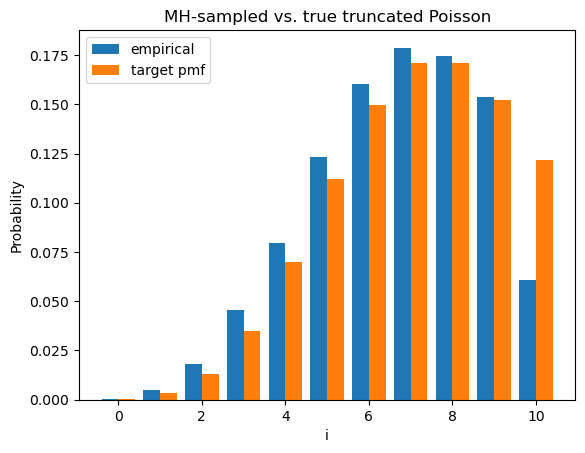

In [ ]:
# cell 3: χ²-test and diagnostics
exp_counts = nsamp * pmf

chi2_stat, p_value = stats.chisquare(counts, f_exp=exp_counts)

print(f"χ² = {chi2_stat:.2f},  p‐value = {p_value:.3f}")

fig, ax = plt.subplots()
ax.bar(xs - 0.2, counts/nsamp, width=0.4, label="empirical")
ax.bar(xs + 0.2, pmf, width=0.4, label="target pmf")
ax.set_xlabel("i")
ax.set_ylabel("Probability")
ax.set_title("MH‐sampled vs. true truncated Poisson")
ax.legend()
plt.show()

## 6.2

In [25]:
# parameters
A1 = A2 = 4.0
m  = 10

# list of valid states and pmf
states = [(i,j) for i in range(m+1) for j in range(m+1) if i+j <= m]
K = len(states)
log_unnorm = np.array([i*math.log(A1)-math.lgamma(i+1) + j*math.log(A2)-math.lgamma(j+1)
                        for i,j in states])
log_unnorm -= log_unnorm.max()
unnorm = np.exp(log_unnorm)
pmf2d  = unnorm/unnorm.sum()
state_to_idx = {st:idx for idx,st in enumerate(states)}

# neighbours for direct MH
neighbours = []
for idx,(i,j) in enumerate(states):
    nbrs = []
    for di,dj in [(1,0),(-1,0),(0,1),(0,-1)]:
        ni,nj = i+di, j+dj
        if 0<=ni<=m and 0<=nj<=m and ni+nj<=m:
            nbrs.append(state_to_idx[(ni,nj)])
    neighbours.append(nbrs)

### 6.2(a)

In [ ]:
def mh2d_direct(n_samples, burn=5000, thin=1, seed=None):
    rng = np.random.default_rng(seed)
    total = burn + n_samples*thin
    samples = np.empty((n_samples,2), int)
    cur = state_to_idx[(int(round(A1)), int(round(A2)))]
    k = 0
    for t in range(total):
        prop = rng.choice(neighbours[cur])
        if rng.random() < min(1, pmf2d[prop]/pmf2d[cur]):
            cur = prop
        if t>=burn and (t-burn)%thin==0:
            samples[k] = states[cur]
            k += 1
    return samples

N = 50_000
samp_a = mh2d_direct(N, seed=2025)
obs_a  = np.bincount([state_to_idx[tuple(x)] for x in samp_a], minlength=K)
exp_a  = N * pmf2d
chi2_a, p_a = stats.chisquare(obs_a, f_exp=exp_a)
print(f"(a) Direct MH: χ² = {chi2_a:.1f}, p = {p_a:.3f}")


(a) Direct MH: χ² = 1648.5, p = 0.000


### 6.2(b)

In [ ]:
def mh2d_coord(n_samples, burn=5000, thin=1, seed=None):
    rng = np.random.default_rng(seed)
    total = burn + n_samples*thin
    samples = np.empty((n_samples,2), int)
    i,j = int(round(A1)), int(round(A2))
    k = 0
    for t in range(total):
        di = rng.choice([-1,1])
        ip = i+di
        if 0 <= ip <= m-j:
            r = (A1**ip/math.factorial(ip)) / (A1**i/math.factorial(i))
            if rng.random() < min(1,r):
                i = ip
        dj = rng.choice([-1,1])
        jp = j+dj
        if 0 <= jp <= m-i:
            r = (A2**jp/math.factorial(jp)) / (A2**j/math.factorial(j))
            if rng.random() < min(1,r):
                j = jp
        if t>=burn and (t-burn)%thin==0:
            samples[k] = (i,j)
            k += 1
    return samples

samp_b = mh2d_coord(N, seed=2025)
obs_b  = np.bincount([state_to_idx[tuple(x)] for x in samp_b], minlength=K)
chi2_b, p_b = stats.chisquare(obs_b, f_exp=exp_a)
print(f"(b) Coord-MH:  χ² = {chi2_b:.1f}, p = {p_b:.3f}")


(b) Coord-MH:  χ² = 220.6, p = 0.000


### 6.2(c)

In [ ]:
logfact = np.array([math.lgamma(k+1) for k in range(m+1)])

def gibbs2d(n_samples, burn=5000, thin=1, seed=None):
    rng = np.random.default_rng(seed)
    total = burn + n_samples*thin
    samples = np.empty((n_samples,2), int)
    i,j = int(round(A1)), int(round(A2))
    k = 0
    for t in range(total):
        max_i = m-j
        vals = np.arange(max_i+1)
        lp = vals*np.log(A1) - logfact[vals]
        lp -= lp.max()
        pi = np.exp(lp); pi /= pi.sum()
        i = rng.choice(vals, p=pi)
        max_j = m-i
        vals = np.arange(max_j+1)
        lp = vals*np.log(A2) - logfact[vals]
        lp -= lp.max()
        pj = np.exp(lp); pj /= pj.sum()
        j = rng.choice(vals, p=pj)
        if t>=burn and (t-burn)%thin==0:
            samples[k] = (i,j)
            k += 1
    return samples

samp_c = gibbs2d(N, seed=2025)
obs_c  = np.bincount([state_to_idx[tuple(x)] for x in samp_c], minlength=K)
chi2_c, p_c = stats.chisquare(obs_c, f_exp=exp_a)
print(f"(c) Gibbs:      χ² = {chi2_c:.1f}, p = {p_c:.3f}")


(c) Gibbs:      χ² = 75.7, p = 0.171


# 6.3


In [ ]:
# prior correlation
rho = 0.5
Sigma = np.array([[1.0, rho],
                  [rho, 1.0]])
prior = multivariate_normal(mean=[0,0], cov=Sigma)
rng = np.random.default_rng(2025)

## 6.3(a)

In [33]:
xi, gamma = prior.rvs(random_state=rng)
theta, psi = np.exp(xi), np.exp(gamma)
print(f"Prior draw: xi={xi:.3f}, gamma={gamma:.3f}  →  theta={theta:.3f}, psi={psi:.3f}")

Prior draw: xi=1.911, gamma=1.937  →  theta=6.758, psi=6.936


## 6.3(b)

In [34]:
n = 10
data_n10 = rng.normal(loc=theta, scale=np.sqrt(psi), size=n)
print("First five observations:", np.round(data_n10[:5],3))

First five observations: [5.338 3.784 0.327 8.773 4.757]


## 6.3(c)

In [ ]:
def log_posterior(xi, gamma, data):
    lp = prior.logpdf([xi, gamma])
    theta = np.exp(xi)
    psi   = np.exp(gamma)
    ll = norm(loc=theta, scale=np.sqrt(psi)).logpdf(data).sum()
    return lp + ll

## 6.3(d)

In [ ]:
def mh_posterior(data, n_samples=20000, burn=5000, thin=1, σ_prop=0.2, seed=None):
    rng = np.random.default_rng(seed)
    total = burn + n_samples*thin
    samples = np.zeros((n_samples,2))
    xi_cur, gamma_cur = prior.rvs(random_state=rng)
    lp_cur = log_posterior(xi_cur, gamma_cur, data)
    k = 0
    for t in range(total):
        xi_prop    = xi_cur    + σ_prop*rng.standard_normal()
        gamma_prop = gamma_cur + σ_prop*rng.standard_normal()
        lp_prop = log_posterior(xi_prop, gamma_prop, data)
        if rng.random() < np.exp(lp_prop - lp_cur):
            xi_cur, gamma_cur, lp_cur = xi_prop, gamma_prop, lp_prop
        if t>=burn and ((t-burn)%thin==0):
            samples[k] = [xi_cur, gamma_cur]
            k += 1
    return samples

samps10 = mh_posterior(data_n10, seed=2025)
theta_samps10 = np.exp(samps10[:,0])
psi_samps10   = np.exp(samps10[:,1])

print("n=10: mean theta =", np.mean(theta_samps10), 
      "mean psi =", np.mean(psi_samps10))


n=10: mean theta = 5.897829802931626 mean psi = 6.270213282745421


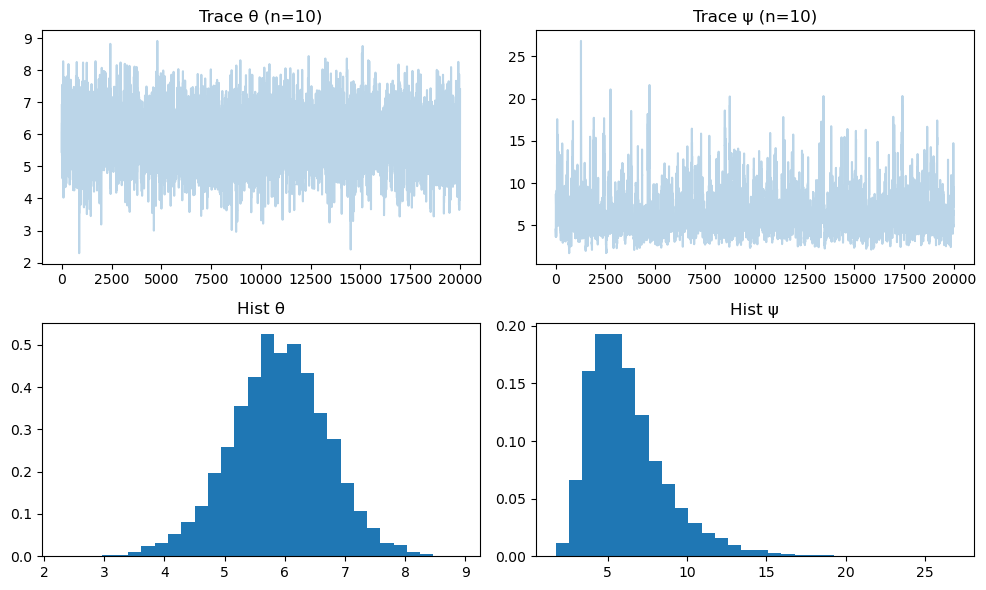

In [ ]:
fig, axes = plt.subplots(2,2,figsize=(10,6))
axes[0,0].plot(theta_samps10, alpha=0.3); axes[0,0].set_title("Trace θ (n=10)")
axes[1,0].hist(theta_samps10, bins=30, density=True); axes[1,0].set_title("Hist θ")
axes[0,1].plot(psi_samps10, alpha=0.3); axes[0,1].set_title("Trace ψ (n=10)")
axes[1,1].hist(psi_samps10, bins=30, density=True); axes[1,1].set_title("Hist ψ")
plt.tight_layout()
plt.show()


## 6.3(e)

In [ ]:
data_n100  = rng.normal(loc=theta, scale=np.sqrt(psi), size=100)
data_n1000 = rng.normal(loc=theta, scale=np.sqrt(psi), size=1000)

samps100  = mh_posterior(data_n100,  seed=2025)
samps1000 = mh_posterior(data_n1000, seed=2025)

θ100  = np.exp(samps100 [:,0])
ψ100  = np.exp(samps100 [:,1])
θ1000 = np.exp(samps1000[:,0])
ψ1000 = np.exp(samps1000[:,1])

for label, θs, ψs in [("n=100",θ100,ψ100),("n=1000",θ1000,ψ1000)]:
    print(f"{label}:  E[θ]={θs.mean():.3f},  E[ψ]={ψs.mean():.3f}")


n=100:  E[θ]=6.790,  E[ψ]=8.970
n=1000:  E[θ]=6.726,  E[ψ]=6.768


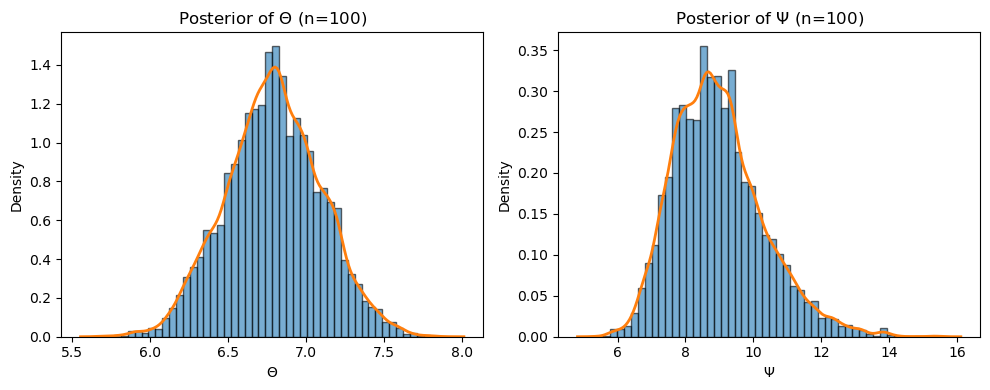

In [ ]:
import seaborn as sns  

fig, axes = plt.subplots(1, 2, figsize=(10,4))

axes[0].hist(θ100, bins=50, density=True, alpha=0.6, edgecolor='k')
try:
    sns.kdeplot(θ100, ax=axes[0], lw=2)
except NameError:
    pass
axes[0].set_title(r'Posterior of $\Theta$ (n=100)')
axes[0].set_xlabel(r'$\Theta$')
axes[0].set_ylabel('Density')

axes[1].hist(ψ100, bins=50, density=True, alpha=0.6, edgecolor='k')
try:
    sns.kdeplot(ψ100, ax=axes[1], lw=2)
except NameError:
    pass
axes[1].set_title(r'Posterior of $\Psi$ (n=100)')
axes[1].set_xlabel(r'$\Psi$')

plt.tight_layout()
plt.savefig('ex6_3_posterior_n100.png', dpi=150)
plt.show()

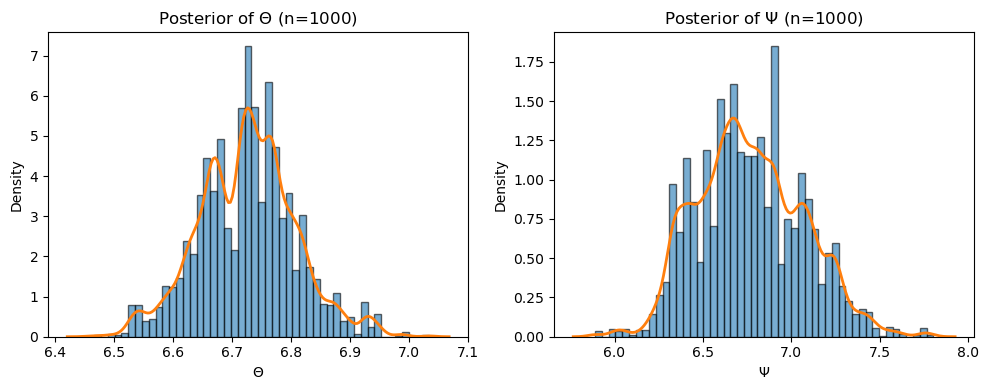

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))

axes[0].hist(θ1000, bins=50, density=True, alpha=0.6, edgecolor='k')
try:
    sns.kdeplot(θ1000, ax=axes[0], lw=2)
except NameError:
    pass
axes[0].set_title(r'Posterior of $\Theta$ (n=1000)')
axes[0].set_xlabel(r'$\Theta$')

axes[1].hist(ψ1000, bins=50, density=True, alpha=0.6, edgecolor='k')
try:
    sns.kdeplot(ψ1000, ax=axes[1], lw=2)
except NameError:
    pass
axes[1].set_title(r'Posterior of $\Psi$ (n=1000)')
axes[1].set_xlabel(r'$\Psi$')

plt.tight_layout()
plt.savefig('ex6_3_posterior_n1000.png', dpi=150)
plt.show()
